In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import our models. The package will take care of downloading the models automatically

model_id = "princeton-nlp/unsup-simcse-roberta-large"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id).to(device)

In [ ]:
from transformers.models.roberta.modeling_roberta import RobertaSelfAttention
from typing import Optional, Tuple
import math
import torch.nn as nn

def forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.FloatTensor] = None,
    head_mask: Optional[torch.FloatTensor] = None,
    encoder_hidden_states: Optional[torch.FloatTensor] = None,
    encoder_attention_mask: Optional[torch.FloatTensor] = None,
    past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
    output_attentions: Optional[bool] = False,
) -> Tuple[torch.Tensor]:
    mixed_query_layer = self.query(hidden_states)

    # If this is instantiated as a cross-attention module, the keys
    # and values come from an encoder; the attention mask needs to be
    # such that the encoder's padding tokens are not attended to.
    is_cross_attention = encoder_hidden_states is not None

    if is_cross_attention and past_key_value is not None:
        # reuse k,v, cross_attentions
        key_layer = past_key_value[0]
        value_layer = past_key_value[1]
        attention_mask = encoder_attention_mask
    elif is_cross_attention:
        key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
        value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
        attention_mask = encoder_attention_mask
    elif past_key_value is not None:
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        key_layer = torch.cat([past_key_value[0], key_layer], dim=2)
        value_layer = torch.cat([past_key_value[1], value_layer], dim=2)
    else:
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))

    query_layer = self.transpose_for_scores(mixed_query_layer)

    use_cache = past_key_value is not None
    if self.is_decoder:
        # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
        # Further calls to cross_attention layer can then reuse all cross-attention
        # key/value_states (first "if" case)
        # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
        # all previous decoder key/value_states. Further calls to uni-directional self-attention
        # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
        # if encoder bi-directional self-attention `past_key_value` is always `None`
        past_key_value = (key_layer, value_layer)

    # print(query_layer.shape, key_layer.shape, value_layer.shape)
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

    if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
        query_length, key_length = query_layer.shape[2], key_layer.shape[2]
        if use_cache:
            position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                -1, 1
            )
        else:
            position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
        position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
        distance = position_ids_l - position_ids_r

        positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
        positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

        if self.position_embedding_type == "relative_key":
            relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
            attention_scores = attention_scores + relative_position_scores
        elif self.position_embedding_type == "relative_key_query":
            relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
            relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
            attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

    attention_scores = attention_scores / math.sqrt(self.attention_head_size)
    if attention_mask is not None:
        # Apply the attention mask is (precomputed for all layers in RobertaModel forward() function)
        attention_scores = attention_scores + attention_mask

    # Normalize the attention scores to probabilities.
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)

    # This is actually dropping out entire tokens to attend to, which might
    # seem a bit unusual, but is taken from the original Transformer paper.
    attention_probs = self.dropout(attention_probs)

    # Mask heads if we want to
    if head_mask is not None:
        attention_probs = attention_probs * head_mask

    context_layer = torch.matmul(attention_probs, value_layer)

    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
    context_layer = context_layer.view(new_context_layer_shape)

    outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

    if self.is_decoder:
        outputs = outputs + (past_key_value,)
    return outputs


RobertaSelfAttention.forward = forward

In [ ]:
# model.encoder.layer[0].attention.self.all_head_size

# Q = Batch x Seq1 x Hid
# K = Batch x (Seq1 + Seq2) x Hid
# V = Batch x (Seq1 + Seq2) x Hid

# QK^-1 = Batch x Seq1 x (Seq1 + Seq2)
# (QK^-1)V = Batch x Seq1 x Hid

In [ ]:
torch.zeros([100,100]).size()[:-1] + (10,10)

In [77]:
import numpy as np

sentence = """

"""

# Q Layer shape:
# Batch Size x Seq Len x Head Size x Dim Per Head

with torch.no_grad():
    input = tokenizer(sentence, return_tensors="pt").to(device)
    output = model(
        **input,
        output_attentions=True)

target = "Paris"
target_id = -1

for i, token in enumerate(input.input_ids[0]):
    if target in tokenizer.decode(token):
        target_id = i
        break

assert target_id != -1
print(target_id)

weights = np.zeros((len(output.attentions), input.input_ids.shape[1]))
for i in range(len(output.attentions)):
    weight = output.attentions[i][0, :, target_id, :]
    weight = torch.sum(weight, axis=0)
    weights[i, :] = weight.cpu().numpy()

labels = [tokenizer.decode([i]) for i in input.input_ids[0].cpu().numpy()]
labels = labels[2:-2]
weights = weights[:, 2:-2]

9


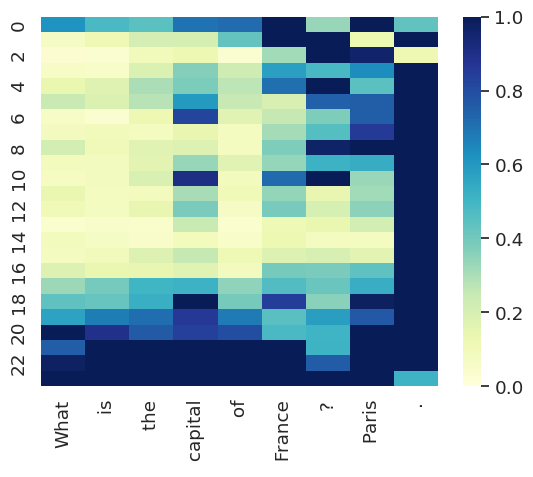

In [78]:
# visualize attention weights
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(weights, cmap="YlGnBu", xticklabels=labels, vmin=0, vmax=1)